# 「Titanic - Machine Learning from Disaster」

## 评价指标

- 任务：二元分类，预测乘客是否存活
- 指标：正确率，正确预测笔数/全体预测数量

In [1]:
# 载入套件
import numpy as np
import pandas as pd

# 载入训练资料、测试资料
train = pd.read_csv('../input/ch01-titanic/train.csv')
test = pd.read_csv('../input/ch01-titanic/test.csv')


In [2]:
# NaN 为资料遗漏，部分机器学习演算法（如GBDT）可以处理这类问题
# 此外，决策树也不受标准化转换特征值的影响，是数据分析竞赛初步分析的主要模型
train.isna().sum().sort_values()


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Embarked         2
Age            177
Cabin          687
dtype: int64

## 特征工程

对训练资料进行**预处理**，转换为模型可以学习的形式，同时新增原本难于发掘、隐含但有助于机器学习演算法预测的特征值。通常特征的好坏决定了竞赛中的排名。

- Numeric
    - scaling: `MinMax`, `Standard`
    - outlier: `winsorization`
    - rank mapping
    - math: `+-*/`, `log`, `sqrt`, fractional_part, `round`
    - concatenation/fusion
- Categorical/Ordinal
    - tree-based model: `Label Encoding`, `Frequency Encoding`
    - linear model: `One-Hot Encoding`
- Datetime
    - periodicity: for example, day number in the week, is_holiday
    - since: for example, days left until next holiday or time passed after last holiday
    - difference: for example, `datetime_feature_1 - datetime_feature_2`
- Coordinate
    - distance from POI
    - center clusters
    - aggregation from surrounding areas: for example, mean housing price
    - rotation
- Missing values
    - mean or median
    - `isnull`
    - reconstruction
  > Xgboost can handle NaN
- Text
    - lowercase, lemmatize or stem, stopwords
    - Bag of words: N-grams, TFiDF
    - word2vec

让我们从前辈的经验学习能建立何种假设以及将假设写成程式码的方法叭！

- 《图灵程序设计丛书 - 精通特征工程》
- https://www.slideshare.net/mlm_kansai/kaggle-138546659
- https://naotaka1128.hatenadiary.jp/entry/kaggle-challenge-story
- https://farid.one/kaggle-solutions/
- https://github.com/nejumi/kaggle_memo

In [3]:
import ydata_profiling
import scienceplots
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
# matplotlib.use('pdf')


pd.plotting.register_matplotlib_converters()
plt.style.use(['fivethirtyeight'])
sns.set(
    # rc={'text.usetex': True},
    font="serif",
    font_scale=1.2
)


# train.profile_report()


In [4]:

train.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


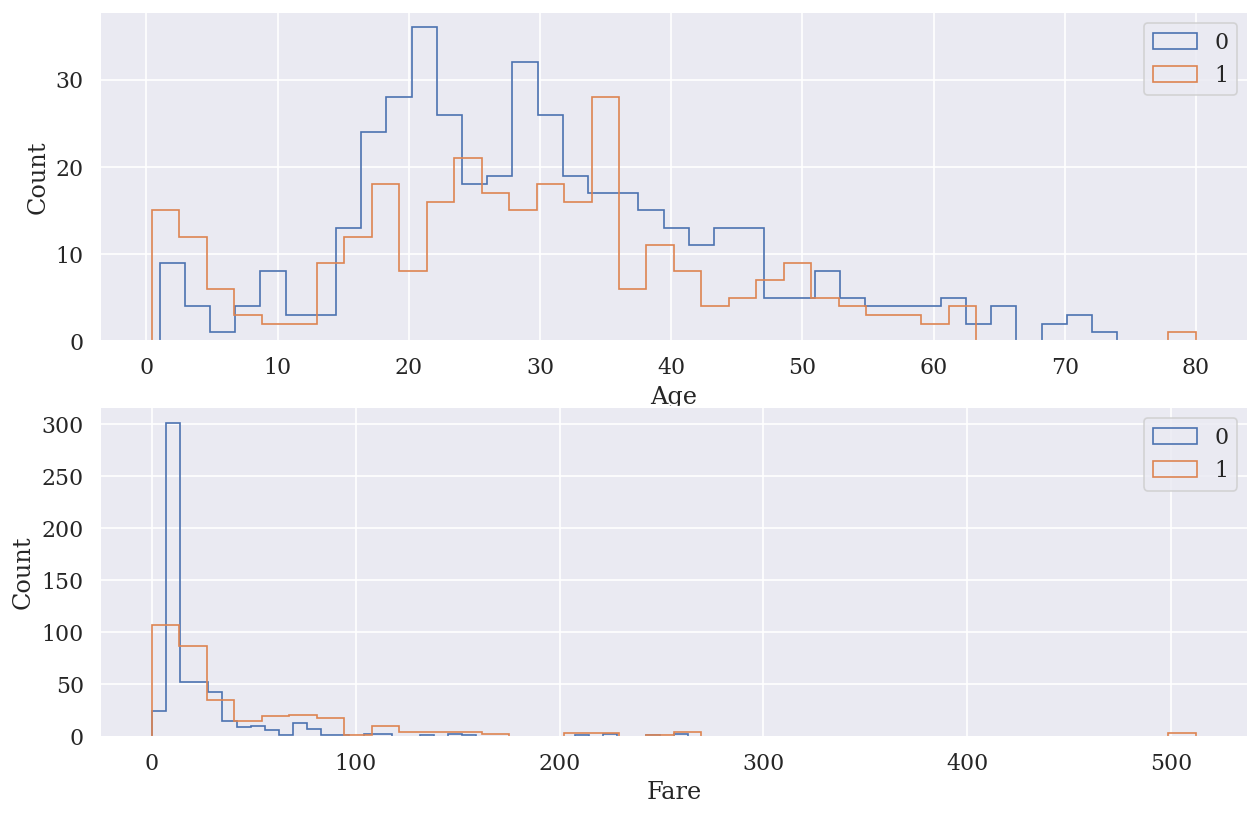

In [5]:
%matplotlib inline
fig, axes = plt.subplots(2, 1, figsize=(11, 8), dpi=120)
for ax, x in zip(axes, ['Age', 'Fare']):
    for label in [0, 1]:
        ax.hist(train.query(f'Survived == {label}')[x].dropna(),
                bins=38, histtype='step', label=str(label))
        ax.set_xlabel(x)
        ax.set_ylabel('Count')
        ax.legend()
plt.show()


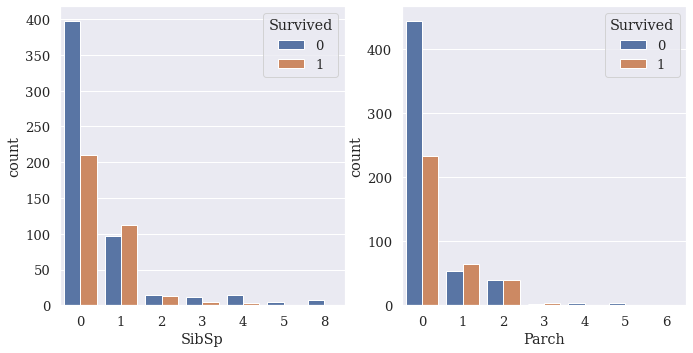

In [6]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5.5))
# SibSp 指共乘的兄弟姐妹与配偶，Parch 指父母亲带小孩上船
# 或许可以尝试加入单身、家庭规格的新增特征的排列组合
for ax, x in zip(axes, ['SibSp', 'Parch']):
    sns.countplot(x=x, hue='Survived', data=train, ax=ax)


<Axes: xlabel='Pclass', ylabel='count'>

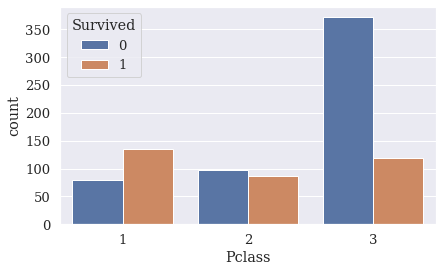

In [7]:
sns.countplot(data=train, x='Pclass', hue='Survived')


<Axes: xlabel='Sex', ylabel='count'>

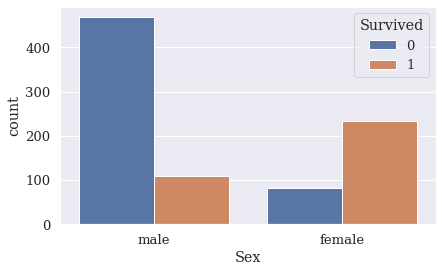

In [8]:
sns.countplot(data=train, x='Sex', hue='Survived')


<Axes: xlabel='Embarked', ylabel='count'>

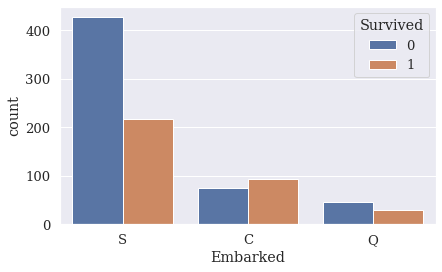

In [9]:
sns.countplot(data=train, x='Embarked', hue='Survived')


In [10]:
from sklearn.preprocessing import LabelEncoder

# 分別取出訓練資料的特徵和標籤
X_train = train.drop(['Survived'], axis=1)
y_train = train['Survived']

# 由於測試資料只有特徵，維持原樣複製一份即可
X_test = test.copy()

# 1. 去除 PassengerId：若放在训练资料内可能会被模型认为是有意义的特征
X_train.drop(['PassengerId'], axis=1, inplace=True)
X_test.drop(['PassengerId'], axis=1, inplace=True)

# 2. 去除 Name, Ticket, Cabin：需经过繁杂的预处理，故删掉
X_train.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)
X_test.drop(['Name', 'Ticket', 'Cabin'], axis=1, inplace=True)

# 3. 對 Sex、Embarked 進行 label encoding：将类别对应到整数
for c in ['Sex', 'Embarked']:
    # 将资料喂给LabelEndoer物件，若有缺失值填入‘NA’
    # 不过，有时候，“遗漏”具有特定意义，所以填补遗漏值不一定是正确做法
    le = LabelEncoder()
    le.fit(X_train[c].fillna('NA'))

    # 透过LabelEncoder物件做转换，若有缺失值填入‘NA’
    X_train[c] = le.transform(X_train[c].fillna('NA'))
    X_test[c] = le.transform(X_test[c].fillna('NA'))


In [11]:
X_train.head()


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,1,22.0,1,0,7.2500,3
1,1,0,38.0,1,0,71.2833,0
2,3,0,26.0,0,0,7.9250,3
3,1,0,35.0,1,0,53.1000,3
4,3,1,35.0,0,0,8.0500,3


<Axes: xlabel='Survived', ylabel='Count'>

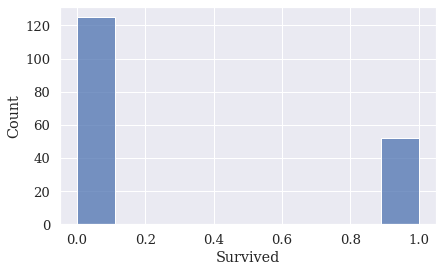

In [12]:
sns.histplot(data=train[train['Age'].isna()], x='Survived')


## 基准模型

![](https://scikit-learn.org/stable/_static/ml_map.png)

常见的机器学习演算法套件有：`XGBoost`, `LightGBM`, `CatBoost`（梯度提升）, `Pytorch`（神经网络）

In [13]:
from xgboost import XGBClassifier
# 建立模型及餵入訓練資料 (與標籤) 以進行學習
# https://www.kaggle.com/code/bminixhofer/deterministic-neural-networks-using-pytorch
model = XGBClassifier(n_estimators=20, random_state=71)
model.fit(X_train, y_train)

# 餵入測試資料以輸出預測值（0～1之间的几率值）
pred = model.predict_proba(X_test)[:, 1]

# 將大於 0.5 的預測值轉為 1、小於等於 0.5 則轉成 0
pred_label = np.where(pred > 0.5, 1, 0)

# 建立提交用的檔案
submission = pd.DataFrame(
    {'PassengerId': test['PassengerId'], 'Survived': pred_label})
submission.to_csv('submission_first.csv', index=False)


![](submission_first.png)
## 评价模型

建立模型的主要目的是要预测未知的资料。对于模型预测能力的优劣，我们必须要在submit之前就自行验证，对模型的能力加以评估。所以，我们通常会将喂给模型的资料分为训练资料、验证资料。同时也便于在过程中，提前终止，避免“过度拟合”这种本末倒置的现象。

In [14]:
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, accuracy_score

# 用 List 保存各 fold 的 accuracy 與 logloss 分數
scores = {
    'accuracy': [],
    'logloss': []
}

# 進行交叉驗證
# 將資料分成四組，1組用於驗證，其9餘組用於訓練，並且輪替10次
kf = KFold(n_splits=10, shuffle=True, random_state=71)
for tr_idx, va_idx in kf.split(X_train):
    # 將資料分為訓練資料和驗證資料 (標籤也是)
    tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
    tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

    # 建立 xgboost 模型並餵入訓練資料與標籤進行學習
    model = XGBClassifier(n_estimators=20, random_state=71)
    model.fit(tr_x, tr_y)

    # 對驗證資料進行預測，輸出預測值的準確率
    va_pred = model.predict_proba(va_x)[:, 1]

    # 計算驗證資料預測值的評價指標，用 logloss 及 accuracy 來算誤差
    logloss = log_loss(va_y, va_pred)
    accuracy = accuracy_score(va_y, va_pred > 0.5)

    # 保存該 fold 的評價指標
    scores['logloss'].append(logloss)
    scores['accuracy'].append(accuracy)

# 輸出各 fold 評價指標的平均值
logloss = np.mean(scores['logloss'])
accuracy = np.mean(scores['accuracy'])
print(f'logloss: {logloss:.4f}, accuracy: {accuracy:.4f}')
# logloss: 0.4270, accuracy: 0.8148 (可能跟書中的數值略有不同)


logloss: 0.4406, accuracy: 0.8159


## 模型调整

在训练前要制定一组超参数，设定模型的学习方法、速度预计模型的复杂度。我们必须将超参数调到最合适的情况，模型才能有最佳的学习成效。

除了手动调整超参数，也有超参数微调工具，例如：[BayesianOptimization](https://github.com/bayesian-optimization/BayesianOptimization), [hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://github.com/optuna/optuna)

In [15]:
# model.get_params()


In [ ]:
# 用于处理排列组合
import itertools

# 準備用於調整的參數【第二次迭代，粒度更细】
param_space = {
    'n_estimators': [18, 19, 20, 21, 22],
    'max_depth': [2, 3, 4],
    'min_child_weight': np.linspace(1.5, 2.5, 10),
}

# 產生超參數 max_depth 與 min_child_weight 的所有組合
param_combinations = itertools.product(param_space['n_estimators'],
                                       param_space['max_depth'],
                                       param_space['min_child_weight'])

# 用 List 保存各參數組合以及各組合的分數
params = []
scores = []

# 對各參數組合的模型進行交叉驗證
# 即网格搜索（Grid Search），也就是超参数的暴力搜索
for n_estimators, max_depth, min_child_weight in param_combinations:

    score_folds = []
    # 進行交叉驗證
    # 將訓練資料分成10分，其中一個作為驗證資料，並不斷輪替交換
    kf = KFold(n_splits=10, shuffle=True, random_state=654321)
    for tr_idx, va_idx in kf.split(X_train):
        # 將資料分為訓練資料與驗證資料
        tr_x, va_x = X_train.iloc[tr_idx], X_train.iloc[va_idx]
        tr_y, va_y = y_train.iloc[tr_idx], y_train.iloc[va_idx]

        # 建立 xgboost 模型並進行訓練
        model = XGBClassifier(n_estimators=n_estimators, random_state=123456,
                              max_depth=max_depth, min_child_weight=min_child_weight)
        model.fit(tr_x, tr_y)

        # 驗證資料的預測值與 logloss 評價指標
        va_pred = model.predict_proba(va_x)[:, 1]
        logloss = log_loss(va_y, va_pred)
        score_folds.append(logloss)

    # 將各 fold 的評價指標進行平均
    score_mean = np.mean(score_folds)

    # 保存參數的組合以及其相對應的評價指標
    params.append({'n_estimators': n_estimators,
                  'max_depth': max_depth, 'min_child_weight': min_child_weight})
    scores.append(score_mean)

# 找出將評價指標分數最佳的參數組合
best_idx = np.argsort(scores)[0]
best_param = params[best_idx]

print(best_param)


## 集成学习

三个臭皮匠，顶过诸葛亮。各模型的不足之处有机会透过其他模型补足，很容易在竞赛尾声，临门一脚，提升分数。本节将建立对数概率模型进行集成，同时，会给予xgboost较高的权重。注意，需要先建立新的特征。

> Linear Quiz Blending

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# 訓練與測試資料
train_x2 = train.drop(['Survived'], axis=1)
test_x2 = test.copy()

# 去除訓練、測試資料中的 PassengerId 欄位
train_x2 = train_x2.drop(['PassengerId'], axis=1)
test_x2 = test_x2.drop(['PassengerId'], axis=1)

# 去除訓練、測試資料中的 Name、Ticket、Cabin 欄位
train_x2 = train_x2.drop(['Name', 'Ticket', 'Cabin'], axis=1)
test_x2 = test_x2.drop(['Name', 'Ticket', 'Cabin'], axis=1)

# 建立 one-hot 編碼的物件與進行相關設置 (告訴它編碼的方式)
cat_cols = ['Sex', 'Embarked', 'Pclass']
ohe = OneHotEncoder(categories='auto', sparse_output=False)
ohe.fit(train_x2[cat_cols].fillna('NA'))

# 對指定的欄位的數據進行 one-hot 編碼
ohe_columns = []
for i, c in enumerate(cat_cols):
    ohe_columns += [f'{c}_{v}' for v in ohe.categories_[i]]

# 對指定欄位的數據進行 one-hot 編碼，將結果存在一個新的 Dataframe
ohe_train_x2 = pd.DataFrame(ohe.transform(
    train_x2[cat_cols].fillna('NA')), columns=ohe_columns)
ohe_test_x2 = pd.DataFrame(ohe.transform(
    test_x2[cat_cols].fillna('NA')), columns=ohe_columns)

# 去除原資料中，指定欄位的數據
train_x2 = train_x2.drop(cat_cols, axis=1)
test_x2 = test_x2.drop(cat_cols, axis=1)

# 將 one-hot 編碼後的 Dataframe 與原資料合併
train_x2 = pd.concat([train_x2, ohe_train_x2], axis=1)
test_x2 = pd.concat([test_x2, ohe_test_x2], axis=1)

# 將欄位中的缺失值，用整個欄位的平均值取代
num_cols = ['Age', 'SibSp', 'Parch', 'Fare']
for col in num_cols:
    train_x2[col].fillna(train_x2[col].mean(), inplace=True)
    test_x2[col].fillna(train_x2[col].mean(), inplace=True)

# 對 Fare 欄位的數據取對數+1
# 通常是为了让资料的变化平滑一点
train_x2['Fare'] = np.log1p(train_x2['Fare'])
test_x2['Fare'] = np.log1p(test_x2['Fare'])


In [ ]:
train_x2.head()


In [ ]:
sns.displot(train['Fare'], bins=100)
plt.show()


In [ ]:
sns.displot(data=train_x2, x='Fare', bins=100)
plt.show()


In [ ]:
from sklearn.linear_model import LogisticRegression

# 建立 xgboost 模型並進行訓練與預測
model_xgb = XGBClassifier(**best_param, random_state=71)
model_xgb.fit(X_train, y_train)
pred_xgb = model_xgb.predict_proba(X_test)[:, 1]

# 建立邏輯斯迴歸模型並進行訓練與預測
# 必須放入與 xgboost 模型不同的特徵，因此另外建立了 train_x2,test_x2
model_lr = LogisticRegression(solver='lbfgs', max_iter=300)
model_lr.fit(train_x2, y_train)
pred_lr = model_lr.predict_proba(test_x2)[:, 1]

# 取得加權平均後的預測值
pred = pred_xgb * 0.8 + pred_lr * 0.2
pred_label = np.where(pred > 0.5, 1, 0)

# 建立提交用的档案
submission = pd.DataFrame(
    {'PassengerId': test['PassengerId'], 'Survived': pred_label})
submission.to_csv('submission_ensemble.csv', index=False)


![](submission_ensemble.png)